In [ ]:
!pip install catboost

In [ ]:
import pandas as pd

import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
import scipy.stats as ss
from sklearn.utils import shuffle
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import plotly.express as px
from tabulate import tabulate


%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.models import Word2Vec

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

class MetastaticDiagnosis:
    def __init__(self):
        self.train_df = None
        self.test_df = None

    def read_data(self, train_csv, test_csv):
        self.train_df = pd.read_csv(train_csv)
        self.test_df = pd.read_csv(test_csv)
        return self.train_df, self.test_df

    def drop_missing_values(self):
        columns_to_drop = ['bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type']
        self.train_df.drop(columns=columns_to_drop, axis=1, inplace=True)
        self.test_df.drop(columns=columns_to_drop, axis=1, inplace=True)
        return self.train_df, self.test_df

    def load_datasets(self, train_csv, val_csv):
        self.train_df = pd.read_csv(train_csv)
        self.val_df = pd.read_csv(val_csv)
        return self.train_df, self.val_df

    def oversample_data(self):
        if self.train_df is not None:
            X = self.train_df.drop(columns=['DiagPeriodL90D'], axis=1)
            y = self.train_df['DiagPeriodL90D']

            ros = RandomOverSampler(random_state=37)
            X_resampled, y_resampled = ros.fit_resample(X, y)

            self.train_df = pd.concat([X_resampled, y_resampled], axis=1)

            return self.train_df

    def get_column_info(self):
        data_types = self.train_df.dtypes
        categorical_cols = data_types[data_types == 'object'].index.tolist()
        categorical_cols = self.train_df.select_dtypes(include=['object', 'category']).columns.tolist()

        numerical_cols = data_types[data_types.isin(['int64', 'float64'])].index.tolist()
        numerical_cols = self.train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

        return categorical_cols, numerical_cols

    def bucket_age(self):
        bins = [0, 18, 30, 40, 50, 65, 120]  # Define age buckets as per your requirements
        labels = ['0-18', '19-30', '31-40', '41-50', '51-65', '65+']
        self.train_df['age_group'] = pd.cut(self.train_df['patient_age'], bins=bins, labels=labels, right=False)


    def impute_data(self):
      if self.train_df is not None:
        categorical_cols, numerical_cols = self.get_column_info()

        columns_to_exclude = ['DiagPeriodL90D', 'patient_id']
        categorical_cols = [col for col in categorical_cols if col not in columns_to_exclude]
        numerical_cols = [col for col in numerical_cols if col not in columns_to_exclude]

        num_imputer = KNNImputer()

        cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

        self.bucket_age()

        if numerical_cols:
            self.train_df[numerical_cols] = num_imputer.fit_transform(self.train_df[numerical_cols])
        if categorical_cols:
            self.train_df[categorical_cols] = cat_imputer.fit_transform(self.train_df[categorical_cols])

        # Custom imputation for 'patient_state', 'payer_type', 'patient_race'
        if 'patient_state' in categorical_cols:
          train_df['patient_state'] = train_df.groupby('patient_zip3')['patient_state'].transform(lambda x: x.fillna(x.mode().iloc[0]))

        if 'payer_type' in categorical_cols:
          train_df['payer_type'] = train_df.groupby(['patient_age'])['payer_type'].transform(lambda x: x.fillna(x.mode().iloc[0]))

        if 'patient_race' in categorical_cols:
          train_df['patient_race'] = train_df.groupby('patient_zip3')['patient_race'].transform(lambda x: x.fillna(x.mode().iloc[0]))

        if self.test_df is not None:
            if numerical_cols:
                self.test_df[numerical_cols] = num_imputer.transform(self.test_df[numerical_cols])
            if categorical_cols:
                self.test_df[categorical_cols] = cat_imputer.transform(self.test_df[categorical_cols])

        if self.val_df is not None:
            if numerical_cols:
                self.val_df[numerical_cols] = num_imputer.transform(self.val_df[numerical_cols])
            if categorical_cols:
                self.val_df[categorical_cols] = cat_imputer.transform(self.val_df[categorical_cols])

        return self.train_df, self.test_df, self.val_df

    def find_unseen_categories(self, train_df, val_df, categorical_cols):
        unseen_categories = {}
        for col in categorical_cols:
            train_categories = set(train_df[col].dropna().unique())
            val_categories = set(val_df[col].dropna().unique())

            unseen = val_categories - train_categories

            if unseen:
                unseen_categories[col] = unseen

        return unseen_categories

    def select_top_features(self, df):
        selected_features = [
            "patient_id", "breast_cancer_diagnosis_code","patient_age","metastatic_cancer_diagnosis_code","payer_type",
            "patient_race", "patient_zip3", "patient_state", "income_household_25_to_35", "rent_burden", "income_household_under_5", "DiagPeriodL90D"
        ]

        return df[selected_features]

    def identify_variable_types(self, dataframe):
        """
        Identifies numerical and categorical variables in the dataframe.

        Parameters:
        - dataframe: A pandas DataFrame.

        Returns:
        - Two lists: one containing numerical variable names and the other containing categorical variable names.
        """
        df_data_types = dataframe.dtypes

        continuous_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()

        categorical_cols = dataframe.select_dtypes(include=['object']).columns.tolist()
        return continuous_cols, categorical_cols

    def scale_continuous_features(self, train_df, val_df, continuous_columns, columns_to_exclude):
        columns_to_scale = [col for col in continuous_columns if col not in columns_to_exclude]

        scaler = MinMaxScaler((0, 1)).fit(train_df[columns_to_scale])

        train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
        val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])

        return train_df, val_df

    def preprocess_data(self, df, train_columns, categorical_columns):
        df_encoded = pd.get_dummies(df, columns=categorical_columns)

        if train_columns is not None:
            for col in set(train_columns) - set(df_encoded.columns):
                df_encoded[col] = 0

            extra_cols = set(df_encoded.columns) - set(train_columns)
            df_encoded = df_encoded.drop(columns=extra_cols, errors='ignore')

            df_encoded = df_encoded.reindex(columns=train_columns, fill_value=0)

        return df_encoded

    def preprocess_and_shuffle(self, df, target_column, is_fit=False):
        """
        Preprocesses the given dataframe, shuffles the data, and separates the target variable.

        Args:
        df (DataFrame): The DataFrame containing the text data and other features.
        target_column (str): The name of the target column.
        is_fit (bool): If True, fit the preprocessor on the data.

        Returns:
        ndarray: An array of processed and shuffled features.
        Series: The shuffled target variable.
        """
        patient_id = df['patient_id'].values

        features = df.drop(columns=['patient_id', target_column])

        processed_features, target = shuffle(features, df[target_column], random_state=42)

        return processed_features, target, patient_id


train_csv_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Train/'
test_csv_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Test/'

train_split_path = '/content/drive/MyDrive/WIDS-Datathon-2024/split/train_set.csv'
val_split_path = '/content/drive/MyDrive/WIDS-Datathon-2024/split/val_set.csv'


meta_obj = MetastaticDiagnosis()

train_csv = train_csv_path + 'training.csv'
test_csv = test_csv_path + 'test.csv'
train_df, test_df = meta_obj.read_data(train_csv, test_csv)
print("Train data shape :", train_df.shape)
print("Test data shape:", test_df.shape, "\n")

train_df, test_df = meta_obj.drop_missing_values()
print("Train data shape after dropping columns:", train_df.shape)
print("Test data shape after dropping columns:", test_df.shape, "\n")

train_df, val_df = meta_obj.load_datasets(train_split_path, val_split_path)
print("Train data shape :", train_df.shape)
print("Validation data shape:", val_df.shape, "\n")

train_df = meta_obj.oversample_data()
print("Train data shape after oversampling columns:", train_df.shape, "\n")

categorical_cols, numerical_cols = meta_obj.get_column_info()
print("categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols, "\n")


train_df, test_df, val_df = meta_obj.impute_data()
print("Train data shape after imputation:", train_df.shape)
print("Test data shape after imputation:", test_df.shape)
print("Validation data shape after imputation:", val_df.shape, "\n")


categorical_cols, _ = meta_obj.get_column_info()

unseen_categories_in_val = meta_obj.find_unseen_categories(train_df, val_df, categorical_cols)
print("Unseen categories in validation:", unseen_categories_in_val, "\n")


train_df_selected = meta_obj.select_top_features(train_df)
val_df_selected = meta_obj.select_top_features(val_df)
print("Train data shape after feature selection:", train_df_selected.shape)
print("Validation data shape after feature selection:", val_df_selected.shape,"\n")

continuous_cols, category_cols = meta_obj.identify_variable_types(train_df_selected)
print(train_df_selected.columns)
print("Continuous columns:", continuous_cols)
print("Categorical columns:", category_cols,"\n")


continuous_cols_to_exclude = ['patient_id', 'DiagPeriodL90D']
train_df_scaled, val_df_scaled = meta_obj.scale_continuous_features(train_df_selected, val_df_selected, continuous_cols, continuous_cols_to_exclude)
print("After scaling train data ",train_df_scaled.shape)
print("After scaling val data", val_df_scaled.shape, "\n")


# Apply preprocessing to the training dataset
#train_df_encoded = meta_obj.preprocess_data(train_df_scaled, None, category_cols)

# Get the list of columns from the transformed training dataset
#train_columns = train_df_encoded.columns.tolist()

# Apply preprocessing to the validation dataset, aligning it to the training columns
#val_df_encoded = meta_obj.preprocess_data(val_df_scaled, train_columns, category_cols)

# Now both datasets should have the same shape
#print("Train data shape after one hot encoding: ", train_df_encoded.shape)
#print("Validation data shape after one hot encoding: ", val_df_encoded.shape, "\n")


# Fit on train data and transform train data
X_train, y_train, train_patient_id = meta_obj.preprocess_and_shuffle(train_df_scaled, 'DiagPeriodL90D', is_fit=True)

# Transform validation data
X_val, y_val, val_patient_id = meta_obj.preprocess_and_shuffle(val_df_scaled, 'DiagPeriodL90D', is_fit=False)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape, "\n")


Train data shape : (12906, 83)
Test data shape: (5792, 82) 

Train data shape after dropping columns: (12906, 80)
Test data shape after dropping columns: (5792, 79) 

Train data shape : (10324, 80)
Validation data shape: (2582, 80) 

Train data shape after oversampling columns: (12896, 80) 

categorical columns: ['patient_race', 'payer_type', 'patient_state', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'Region', 'Division']
Numerical columns: ['patient_id', 'patient_zip3', 'patient_age', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'inco

<ipython-input-11-1ca78f5660eb>:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
<ipython-input-11-1ca78f5660eb>:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])


0:	learn: 0.6885633	total: 11.1ms	remaining: 11s
10:	learn: 0.6481685	total: 244ms	remaining: 21.9s
20:	learn: 0.6164367	total: 520ms	remaining: 24.3s
30:	learn: 0.5914298	total: 792ms	remaining: 24.7s
40:	learn: 0.5711909	total: 1.15s	remaining: 26.9s
50:	learn: 0.5547954	total: 1.53s	remaining: 28.4s
60:	learn: 0.5421186	total: 1.81s	remaining: 27.9s
70:	learn: 0.5307915	total: 2.34s	remaining: 30.7s
80:	learn: 0.5221306	total: 2.77s	remaining: 31.4s
90:	learn: 0.5147521	total: 3.16s	remaining: 31.5s
100:	learn: 0.5078907	total: 3.67s	remaining: 32.7s
110:	learn: 0.5018853	total: 4.12s	remaining: 33s
120:	learn: 0.4965759	total: 4.61s	remaining: 33.5s
130:	learn: 0.4901096	total: 5.13s	remaining: 34.1s
140:	learn: 0.4845917	total: 5.52s	remaining: 33.6s
150:	learn: 0.4785156	total: 6s	remaining: 33.7s
160:	learn: 0.4708984	total: 6.53s	remaining: 34s
170:	learn: 0.4635940	total: 7.02s	remaining: 34s
180:	learn: 0.4574001	total: 7.56s	remaining: 34.2s
190:	learn: 0.4518482	total: 8.13

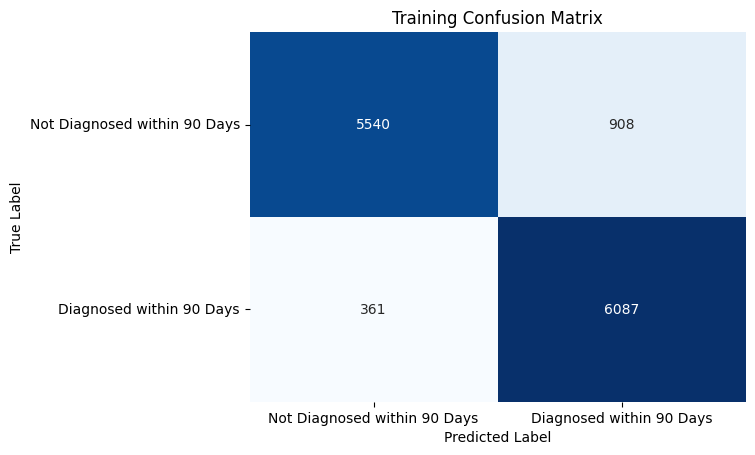

Validation Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.78      0.59      0.67       970
    Diagnosed within 90 Days       0.78      0.90      0.84      1612

                    accuracy                           0.78      2582
                   macro avg       0.78      0.75      0.76      2582
                weighted avg       0.78      0.78      0.78      2582



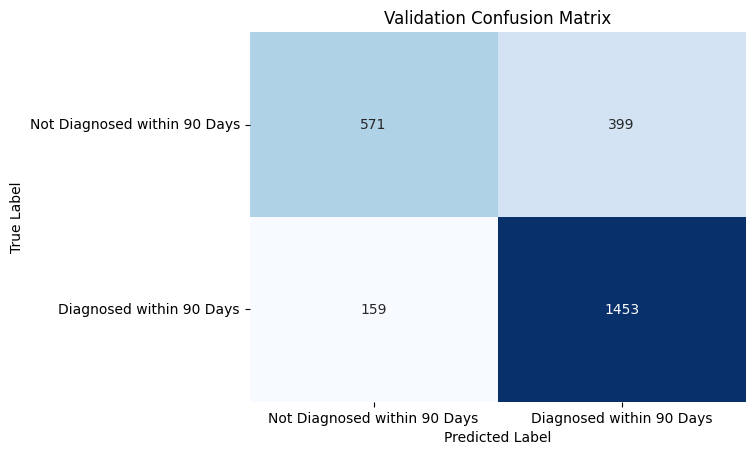


 ROC Curve


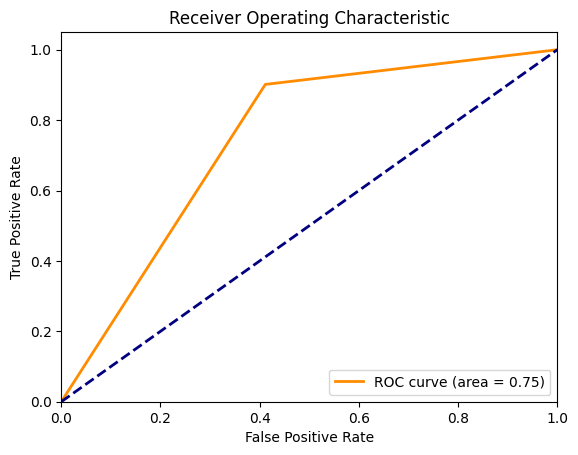

In [ ]:

class ModelBuilder:
    def __init__(self):
        self.cf_classifier = None

    def build_catboost_classifier(self):

        # Create a random forest classifier
        cf_classifier = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=10, verbose=10)

        self.cf_classifier = cf_classifier

    def train(self, X_train, y_train, category_cols):
        if self.cf_classifier is not None:
            self.cf_classifier.fit(X_train, y_train, cat_features=category_cols)
        else:
            raise ValueError("Model has not been built yet.")
        return self.cf_classifier

    def generate_submission(self, X_val, y_val, val_patient_id, result_path):
        if self.cf_classifier is None:
            raise ValueError("Model has not been built yet.")

        val_yhat_probs_sub = self.cf_classifier.predict_proba(X_val)

        submission = pd.DataFrame({
            'patient_id': val_patient_id,
            'DiagPeriodL90D': y_val,
            'prediction_probability': val_yhat_probs_sub[:, 1]
        })

        submission.to_csv(result_path + 'a_catboost_submission.csv', index=False)

    def calculate_training_classification_report(self, y_train, train_yhat_probs,classes):
        report = classification_report(y_train, train_yhat_probs, target_names=classes)
        return report

    def plot_training_confusion_matrix(self, y_train, train_yhat_probs, classes):
        train_cm = confusion_matrix(y_train, train_yhat_probs)
        ax = sns.heatmap(train_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Training Confusion Matrix')
        plt.show()

    def calculate_validation_classification_report(self, y_val, val_yhat_probs, classes):
        report = classification_report(y_val, val_yhat_probs, target_names=classes)
        return report

    def plot_validation_confusion_matrix(self, y_val, val_yhat_probs, classes):
        val_cm = confusion_matrix(y_val, val_yhat_probs)
        ax = sns.heatmap(val_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Validation Confusion Matrix')
        plt.show()

    def plot_roc_curve(self, y_true, y_scores):
      """
      Plot the Receiver Operating Characteristic (ROC) curve.

      Args:
      y_true (array-like): True binary labels.
      y_scores (array-like): Target scores, can either be probability estimates of the positive class or confidence values.

      Returns:
      None (displays the ROC curve plot).
      """
      fpr, tpr, _ = roc_curve(y_true, y_scores)
      roc_auc = auc(fpr, tpr)

      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()



model_trainer = ModelBuilder()

model_trainer.build_catboost_classifier()

cf_classifier = model_trainer.train(X_train, y_train, category_cols)

result_path = '/content/drive/MyDrive/HS/'
model_trainer.generate_submission(X_val, y_val, val_patient_id, result_path)


train_yhat_probs = cf_classifier.predict(X_train)
val_yhat_probs = cf_classifier.predict(X_val)

classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]


train_classification_report = model_trainer.calculate_training_classification_report(y_train, train_yhat_probs,classes)
print("Training Classification Report:\n", train_classification_report)

model_trainer.plot_training_confusion_matrix(y_train, train_yhat_probs,classes)


val_classification_report = model_trainer.calculate_validation_classification_report(y_val, val_yhat_probs,classes)
print("Validation Classification Report:\n", val_classification_report)

model_trainer.plot_validation_confusion_matrix(y_val, val_yhat_probs,classes)

print("\n ROC Curve")
y_true = y_val
y_scores = val_yhat_probs
model_trainer.plot_roc_curve(y_true, y_scores)

In [ ]:
# Calculate metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score

metrics = {
    'Accuracy': accuracy_score,
    'Balanced Accuracy': balanced_accuracy_score,
    'ROC AUC': roc_auc_score,
    'F1 Score': f1_score
}

for name, metric in metrics.items():
    train_score = metric(y_train, train_yhat_probs)
    val_score = metric(y_val, val_yhat_probs)
    print(f'{name}:')
    print(f'  Training: {train_score:.2f}')
    print(f'  Validation: {val_score:.2f}')

Accuracy:
  Training: 0.90
  Validation: 0.78
Balanced Accuracy:
  Training: 0.90
  Validation: 0.75
ROC AUC:
  Training: 0.90
  Validation: 0.75
F1 Score:
  Training: 0.91
  Validation: 0.84
